In [1]:
from __future__ import print_function
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT;
import root_numpy as rnp
%matplotlib notebook

Welcome to ROOTaaS 6.06/06


# Loading the input into numpy

Using root_numpy to make structured arrays.

In [2]:
#filename = '/Users/sfarrell/Atlas/xaod/mc15_13TeV.361023.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ3W.merge.DAOD_EXOT3.e3668_s2576_s2132_r7728_r7676_p2613/DAOD_EXOT3.08204445._000002.pool.root.1'
filename = '/Users/sfarrell/Atlas/xaod/mc15_13TeV.403554.MadGraphPythia8EvtGen_A14NNPDF23LO_GG_RPV10_1000_250.merge.DAOD_EXOT3.e5079_a766_a821_r7676_p2646/DAOD_EXOT3.08548063._000001.pool.root.1'

In [3]:
# Branch names to read in and rename for convenience
branchMap = {
    'CaloCalTopoClustersAuxDyn.calEta' : 'ClusEta',
    'CaloCalTopoClustersAuxDyn.calPhi' : 'ClusPhi',
    'CaloCalTopoClustersAuxDyn.calE' : 'ClusE',
    'AntiKt10LCTopoTrimmedPtFrac5SmallR20JetsAux.pt' : 'FatJetPt',
    'AntiKt10LCTopoTrimmedPtFrac5SmallR20JetsAux.eta' : 'FatJetEta',
    'AntiKt10LCTopoTrimmedPtFrac5SmallR20JetsAux.phi' : 'FatJetPhi',
    'AntiKt10LCTopoTrimmedPtFrac5SmallR20JetsAux.m' : 'FatJetM',
}

In [4]:
entries = rnp.root2array(filename, treename='CollectionTree',
                         branches=branchMap.keys(),
                         ) #start=0, stop=10000)
entries.dtype.names = branchMap.values()
print('Entries:', entries.size)

TClass::Init:0: RuntimeWarning: no dictionary for class DataHeader_p5 is available
TClass::Init:0: RuntimeWarning: no dictionary for class DataHeaderElement_p5 is available
TClass::Init:0: RuntimeWarning: no dictionary for class DataHeaderForm_p5 is available
TClass::Init:0: RuntimeWarning: no dictionary for class IOVMetaDataContainer_p1 is available
TClass::Init:0: RuntimeWarning: no dictionary for class IOVPayloadContainer_p1 is available
TClass::Init:0: RuntimeWarning: no dictionary for class IOVPayloadContainer_p1::CondAttrListCollection_p1 is available
TClass::Init:0: RuntimeWarning: no dictionary for class IOVPayloadContainer_p1::CondAttrListEntry_p1 is available
TClass::Init:0: RuntimeWarning: no dictionary for class IOVPayloadContainer_p1::IOVRange_p1 is available
TClass::Init:0: RuntimeWarning: no dictionary for class AttrListIndexes is available
TClass::Init:0: RuntimeWarning: no dictionary for class xAOD::CutBookkeeper_v1 is available
TClass::Init:0: RuntimeWarning: no dicti

Entries: 9973


In [5]:
entries.dtype

dtype([('FatJetPhi', 'O'), ('FatJetEta', 'O'), ('FatJetM', 'O'), ('ClusEta', 'O'), ('ClusE', 'O'), ('ClusPhi', 'O'), ('FatJetPt', 'O')])

# Indexing and selection with numpy
Since the data is structured, we can index by key name and do some fancy stuff.

In [6]:
# Multiple ways to dump variables for a specific event.
# I'm actually surprised these both work.
print(entries[0]['FatJetPt'])
print(entries['FatJetPt'][0])

[ 556584.4375      295621.21875     201845.921875    161042.140625
   93007.1640625    71875.1484375    69584.0625       58491.34765625
   56537.53125      50488.59375      48581.41796875   45340.34375
   42120.62890625]
[ 556584.4375      295621.21875     201845.921875    161042.140625
   93007.1640625    71875.1484375    69584.0625       58491.34765625
   56537.53125      50488.59375      48581.41796875   45340.34375
   42120.62890625]


In [7]:
# Perform object selections on one event
event = entries[3]
event['FatJetPt'] > 300000

array([ True, False, False, False, False, False, False, False, False, False], dtype=bool)

In [8]:
# Select fatjets with pt > 200 GeV for all events in one go
f = np.vectorize(lambda jetPts: jetPts > 200000, otypes=[np.ndarray])
selectedJets = f(entries['FatJetPt'])
print(selectedJets)

[ array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)
 array([ True,  True,  True, False, False, False, False, False, False], dtype=bool)
 array([ True,  True,  True,  True, False, False, False, False, False,
       False, False], dtype=bool)
 ...,
 array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False], dtype=bool)
 array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False], dtype=bool)
 array([ True,  True, False, False, False, False, False], dtype=bool)]


In [9]:
# Select events with at least 2 selected jets
countSelected = np.vectorize(sum)
numJets = countSelected(selectedJets)
selectedEvents = numJets >= 2
print(numJets)
print(selectedEvents)

[3 3 4 ..., 4 4 2]
[ True  True  True ...,  True  True  True]


## Physics selections and variables
Enough playing around. Let's test out the actual physics selections. The code has been put into the physics_selections module in the containing directory of this notebook.

In [10]:
from physics_selections import (select_fatjets, is_baseline_event,
                                sum_fatjet_mass, is_signal_region_event)

In [11]:
vec_select_fatjets = np.vectorize(select_fatjets, otypes=[np.ndarray])
vec_select_baseline_events = np.vectorize(is_baseline_event)
selectedFatJets = vec_select_fatjets(entries['FatJetPt'], entries['FatJetEta'])
baselineEvents = vec_select_baseline_events(entries['FatJetPt'], selectedFatJets)
print('Baseline selected events: %d / %d' % (np.sum(baselineEvents), entries.size))

Baseline selected events: 7042 / 9973


In [12]:
# Calculate the summed jet mass for all events
summedMasses = np.vectorize(sum_fatjet_mass)(entries['FatJetM'], selectedFatJets)
print(summedMasses[baselineEvents])

[ 350049.59277344  641813.953125    688428.45507812 ...,  702532.22558594
  343132.76757812  495058.11132812]


In [13]:
vec_select_sr_events = np.vectorize(is_signal_region_event)
signalEvents = vec_select_sr_events(summedMasses, entries['FatJetPt'], entries['FatJetEta'],
                                    selectedFatJets, baselineEvents)
signalEntries = entries[signalEvents]
numSignalEvents = np.sum(signalEvents)
print('Signal events: %d / %d' % (numSignalEvents, entries.size))

Signal events: 254 / 9973


# Drawing signal region events

In [18]:
def get_hist2d(event):
    """Convert event into the calo-cluster image"""
    return np.histogram2d(event['ClusEta'], event['ClusPhi'],
                          bins=(50, 50), weights=event['ClusE'],
                          range=[[-2.5, 2.5], [-3.15, 3.15]])[0]

def plot_calo_image(h2d):
    """Plot a calo-image on the current axes"""
    plt.imshow(np.log10(h2d).T, #extent=[-2.,2.,-3.14, 3.14],
               extent=[-2.5, 2.5, -3.15, 3.15],
               interpolation='none', aspect='auto', origin='low')
    plt.colorbar(label='Cluster energy [Log(MeV)]')
    plt.xlabel('eta')
    plt.ylabel('phi')

def plot_jets(jetEtas, jetPhis, jetRadius=1):
    """Plot jet circles on the current axes"""
    for eta, phi in zip(jetEtas, jetPhis):
        circle = plt.Circle((eta, phi), radius=jetRadius, facecolor='none')
        plt.gcf().gca().add_artist(circle)

In [19]:
# Pick out a sample of signal region events.
# The indexing is now starting to get very confusing.
numSample = 4
sampleIdxs = np.random.choice(np.arange(numSignalEvents), numSample, replace=False)
sampleEntries = signalEntries[sampleIdxs]
sampleFatJets = selectedFatJets[signalEvents][sampleIdxs] # are we lost yet?
assert(sampleEntries.size == sampleFatJets.size)

In [20]:
# Get the quantities to plot
hists = [get_hist2d(ev) for ev in sampleEntries]
jetEtas = [etas[jets] for (etas, jets) in zip(sampleEntries['FatJetEta'], sampleFatJets)]
jetPhis = [phis[jets] for (phis, jets) in zip(sampleEntries['FatJetPhi'], sampleFatJets)]

<IPython.core.display.Javascript object>


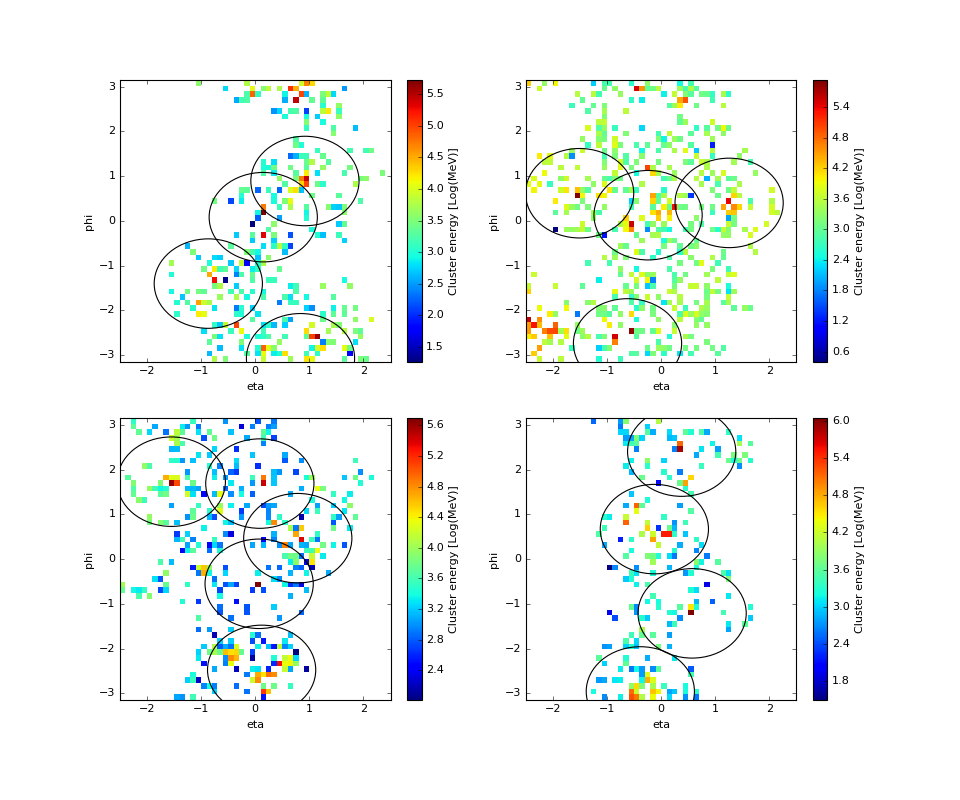

In [21]:
# Draw the calo images and draw the selected fat jets as circles
plt.figure(figsize=(12, 10))
plt.subplot(221)
plot_calo_image(hists[0])
plot_jets(jetEtas[0], jetPhis[0])

plt.subplot(222)
plot_calo_image(hists[1])
plot_jets(jetEtas[1], jetPhis[1])

plt.subplot(223)
plot_calo_image(hists[2])
plot_jets(jetEtas[2], jetPhis[2])

plt.subplot(224)
plot_calo_image(hists[3])
plot_jets(jetEtas[3], jetPhis[3])